In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gower
import umap

from scipy.stats import chi2_contingency

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, make_scorer

pd.set_option('future.no_silent_downcasting', True)

In [2]:
!pip install --upgrade scikit-learn umap-learn
import sklearn
print("Versión cargada:", sklearn.__version__)

Versión cargada: 1.7.2


In [3]:
# ==========================================
# 1. CARGA DE DATOS
# ==========================================
# ruta pablo
ruta = "data_adolescentes/adolescentes_ensanut2023_w_n.csv"
# ruta dani
# ruta = "/Users/danielarenee/Desktop/MD_proyecto_final/data_adolescentes/adolescentes_ensanut2023_w_n.csv"
data = pd.read_csv(ruta, delimiter=";")

In [27]:
# ==========================================
# 2. CREACIÓN DE VARIABLE TARGET
# ==========================================

variables_depresion = ['d0601a', 'd0601b', 'd0601c', 'd0601d', 'd0601f', 'd0601g']
data_copy = data.copy()

# Convertir a numérico
for var in variables_depresion:
    data_copy[var] = pd.to_numeric(data_copy[var].replace(' ', np.nan), errors='coerce')

# Invertir d0601f y crear score (rango: 6-23)
data_copy['d0601f_inv'] = 5 - data_copy['d0601f']
variables_score = ['d0601a', 'd0601b', 'd0601c', 'd0601d', 'd0601f_inv', 'd0601g']
data_copy['score_depresion'] = data_copy[variables_score].sum(axis=1)

# Clasificar en 4 categorías ordinales (≤6, 7-8, 9-11, ≥12)
def clasificar_depresion(score):
    if pd.isna(score):
        return np.nan
    elif score <= 10:
        return "No requiere atencion"
    else:
        return "Requiere atencion"

data_copy['nivel_depresion'] = data_copy['score_depresion'].apply(clasificar_depresion)

# Mostrar distribución
print("Distribución de clases:")
for nivel, n in data_copy['nivel_depresion'].value_counts().items():
    print(f"  {nivel:<15}: {n:>6} ({n/len(data_copy)*100:>5.1f}%)")

Distribución de clases:
  No requiere atencion:   1601 ( 83.2%)
  Requiere atencion:    323 ( 16.8%)


In [28]:
# ==========================================
# 3. SELECCIÓN DE FEATURES
# ==========================================
# Total: 21 features
ft_demograficas = ['edad', 'sexo']
ft_alimentarias = ['d06a1', 'd06a2', 'd06a3', 'd06a4', 'd06a5', 'd06a6', 'd06a7', 'd06a8', 'd06a9', 'd06a10']

# d0701 - accidentes
# d0801 - agresión
# d0810 - abuso sexual
# d0817 - pensamientos suicidas
# d0819 - autolesiones
# d0101 - consumo de tabaco
# d0108 - consumo de alcohol
# d0421 - ansiedad
# d0601e - sueño

ft_extras = ['d0701', 'd0801', 'd0810', 'd0817', 'd0819', 'd0101', 'd0108', 'd0421', 'd0601e']

selected_features = ft_demograficas + ft_alimentarias + ft_extras


In [29]:
# ==========================================
# 4. PREPARACIÓN DE DATOS
# ==========================================
# Crear dataset con features + target
df_model = data_copy[selected_features + ['nivel_depresion']].copy()

# Convertir features a numérico
for col in selected_features:
    df_model[col] = pd.to_numeric(df_model[col].replace(' ', np.nan), errors='coerce')

# Eliminar filas sin target o con missing en features
df_clean = df_model.dropna()

print(f"Observaciones: {len(data_copy)} → {len(df_clean)} (perdidas: {len(data_copy)-len(df_clean)})")


Observaciones: 1924 → 1592 (perdidas: 332)


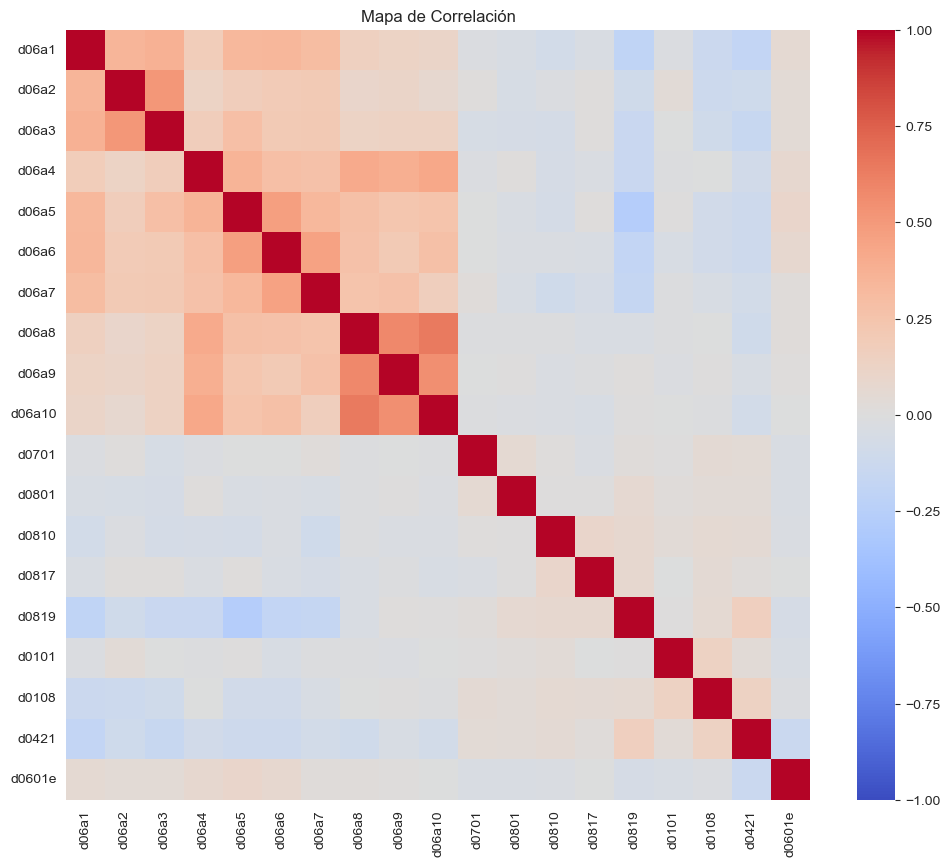

d06a8   d06a10    0.641805
d06a10  d06a8     0.641805
d06a8   d06a9     0.584085
d06a9   d06a8     0.584085
        d06a10    0.550175
d06a10  d06a9     0.550175
d06a3   d06a2     0.513320
d06a2   d06a3     0.513320
d06a5   d06a6     0.473803
d06a6   d06a5     0.473803
dtype: float64


In [30]:
# ==========================================
# 4.1 PREPARACIÓN DE DATOS // CORRELACIÓN Y D.R PREP.
# ==========================================

cols = ["edad", "sexo", "nivel_depresion"]
df_analisis = df_clean.drop(columns=cols)

plt.figure(figsize=(12, 10))
corr_matrix = df_analisis.corr()

sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Mapa de Correlación")
plt.show()

corr = df_analisis.corr().abs()

top_corr = (
    corr.where(~np.eye(corr.shape[0], dtype=bool))
        .unstack()
        .dropna()
        .sort_values(ascending=False)
)

print(top_corr.head(10))


C:\Users\ps222\anaconda3\Lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
C:\Users\ps222\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


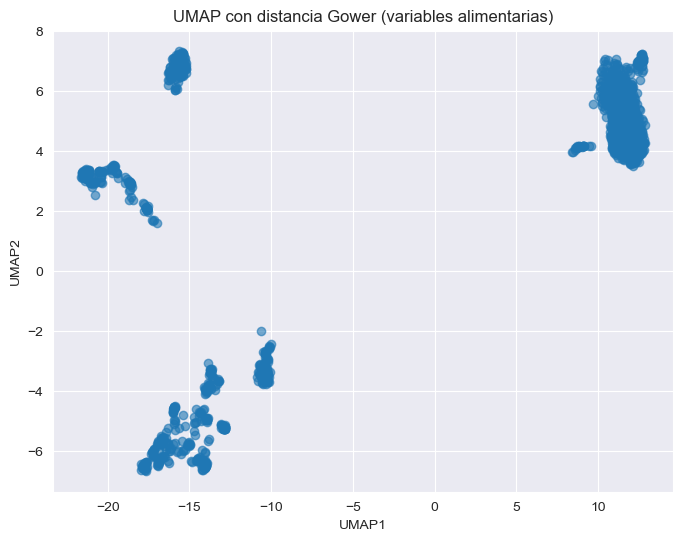

In [31]:
# ==========================================
# 5. UMAP - Reducción de dimensionalidad
# ==========================================

cols_alimentacion = ft_alimentarias
X = df_analisis[cols_alimentacion].copy()
# X = X.astype('object')
dist_matrix = gower.gower_matrix(X.astype('object'))

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='precomputed',
    random_state=42
)

reducer.fit(dist_matrix)
coords_umap = reducer.embedding_

plt.figure(figsize=(8,6))
plt.scatter(coords_umap[:,0], coords_umap[:,1], alpha=0.6)
plt.title("UMAP con distancia Gower (variables alimentarias)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()


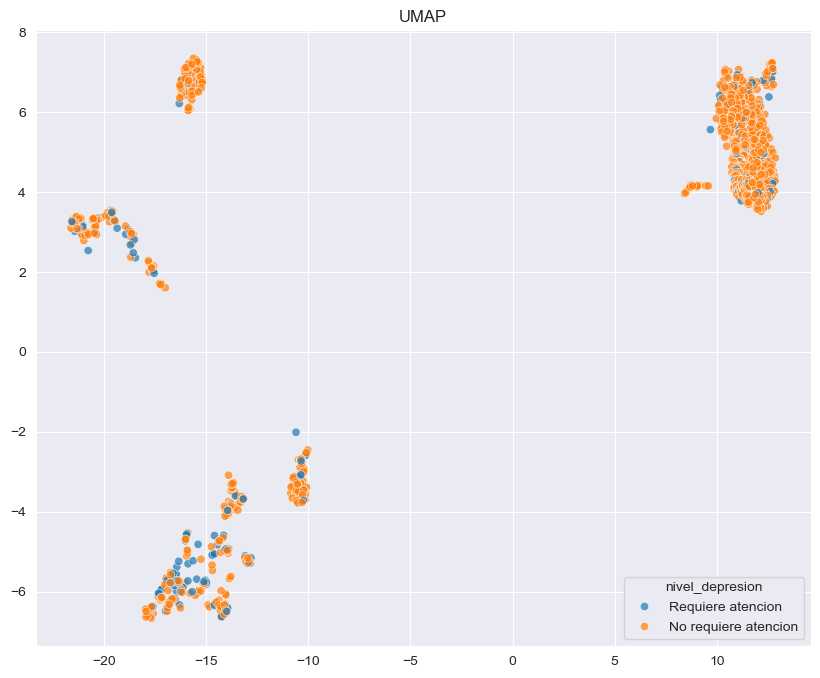

In [32]:
# Visualización del espacio UMAP coloreado por nivel de depresión

colores = df_clean['nivel_depresion']

plt.figure(figsize=(10, 8))
sns.scatterplot(x=coords_umap[:,0], y=coords_umap[:,1], hue=colores, alpha=0.7)
plt.title("UMAP")
plt.show()

In [33]:
print("Shape matriz distancias:", dist_matrix.shape)
print("Shape embedding:", coords_umap.shape)


Shape matriz distancias: (1592, 1592)
Shape embedding: (1592, 2)


In [34]:
pd.DataFrame(coords_umap, columns=["UMAP1", "UMAP2"]).var()

UMAP1    186.846527
UMAP2     21.976305
dtype: float32

In [35]:
# ==========================================
# CREAR DATAFRAME DE UMAP PARA USO EN EL ÁRBOL
# ==========================================

df_umap = pd.DataFrame(coords_umap, columns=["UMAP1", "UMAP2"], index=df_clean.index)

print(df_umap.head())
print(df_umap.shape)


       UMAP1     UMAP2
0 -15.551192  6.966113
1 -21.517406  3.252255
2  11.138290  5.539479
3 -19.648222  3.542990
5  10.679192  5.396922
(1592, 2)


In [36]:
# Integración de variables reducidas (UMAP) y selección final de predictores

df_final = pd.concat([df_clean, df_umap], axis=1)
df_final = df_final.drop(columns=ft_alimentarias)

X = df_final.drop(columns=['nivel_depresion'])
y = df_final['nivel_depresion']

In [53]:
configuraciones = {
    'Árbol 1 - Poco profundo': {
        'max_depth': 3, 'min_samples_split': 50, 'min_samples_leaf': 20,
        'criterion': 'gini', 'class_weight': 'balanced'
    },
    'Árbol 2 - Moderado': {
        'max_depth': 5, 'min_samples_split': 30, 'min_samples_leaf': 15,
        'criterion': 'gini', 'class_weight': 'balanced'
    },
    'Árbol 3 - Profundo': {
        'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 10,
        'criterion': 'gini', 'class_weight': 'balanced'
    },
    'Árbol 4 - Muy Profundo': {
        'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 8,
        'criterion': 'gini', 'class_weight': 'balanced'
    },
    'Árbol 5 - Entropy Moderado': {
        'max_depth': 5, 'min_samples_split': 30, 'min_samples_leaf': 15,
        'criterion': 'entropy', 'class_weight': 'balanced'
    },
    'Árbol 6 - Entropy Profundo': {
        'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 10,
        'criterion': 'entropy', 'class_weight': 'balanced'
    }
}

def evaluar_modelo(nombre, config):
    modelo = DecisionTreeClassifier(random_state=42, **config)

    labels = sorted(y.unique())
    pos_label = labels[1]

    scoring = {
        'accuracy': 'accuracy',
        'f1_weighted': 'f1_weighted',
        'recall': make_scorer(recall_score, pos_label=pos_label, zero_division=0)
    }

    cv_results = cross_validate(modelo, X, y, cv=5, scoring=scoring)
    modelo.fit(X, y)

    return {
        'Modelo': nombre,
        'Accuracy': cv_results['test_accuracy'].mean(),
        'F1_weighted': cv_results['test_f1_weighted'].mean(),
        'Recall': cv_results['test_recall'].mean(),
        'Std_Recall': cv_results['test_recall'].std(),
        'Config': config,
        'Objeto': modelo
    }

resultados = []
for nombre, cfg in configuraciones.items():
    resultados.append(evaluar_modelo(nombre, cfg))

df_resultados = pd.DataFrame(resultados).sort_values("Recall", ascending=False)

print("\nResultados ordenados por Recall:")
print(df_resultados)

df_resultados



Resultados ordenados por Recall:
                       Modelo  Accuracy  F1_weighted    Recall  Std_Recall  \
4  Árbol 5 - Entropy Moderado  0.640049     0.688839  0.686939    0.045499   
1          Árbol 2 - Moderado  0.666418     0.709420  0.674531    0.089546   
0     Árbol 1 - Poco profundo  0.691532     0.729315  0.651347    0.104365   
5  Árbol 6 - Entropy Profundo  0.654502     0.699023  0.646612    0.067457   
2          Árbol 3 - Profundo  0.648804     0.693711  0.569959    0.057328   
3      Árbol 4 - Muy Profundo  0.660736     0.701986  0.521796    0.103757   

                                              Config  \
4  {'max_depth': 5, 'min_samples_split': 30, 'min...   
1  {'max_depth': 5, 'min_samples_split': 30, 'min...   
0  {'max_depth': 3, 'min_samples_split': 50, 'min...   
5  {'max_depth': 7, 'min_samples_split': 20, 'min...   
2  {'max_depth': 7, 'min_samples_split': 20, 'min...   
3  {'max_depth': 10, 'min_samples_split': 15, 'mi...   

                          

,Modelo,Accuracy,F1_weighted,Recall,Std_Recall,Config,Objeto
4,Árbol 5 - Entropy Moderado,0.640049,0.688839,0.686939,0.045499,"{'max_depth': 5, 'min_samples_split': 30, 'min...",DecisionTreeClassifier(class_weight='balanced'...
1,Árbol 2 - Moderado,0.666418,0.709420,0.674531,0.089546,"{'max_depth': 5, 'min_samples_split': 30, 'min...",DecisionTreeClassifier(class_weight='balanced'...
0,Árbol 1 - Poco profundo,0.691532,0.729315,0.651347,0.104365,"{'max_depth': 3, 'min_samples_split': 50, 'min...",DecisionTreeClassifier(class_weight='balanced'...
5,Árbol 6 - Entropy Profundo,0.654502,0.699023,0.646612,0.067457,"{'max_depth': 7, 'min_samples_split': 20, 'min...",DecisionTreeClassifier(class_weight='balanced'...
2,Árbol 3 - Profundo,0.648804,0.693711,0.569959,0.057328,"{'max_depth': 7, 'min_samples_split': 20, 'min...",DecisionTreeClassifier(class_weight='balanced'...
3,Árbol 4 - Muy Profundo,0.660736,0.701986,0.521796,0.103757,"{'max_depth': 10, 'min_samples_split': 15, 'mi...",DecisionTreeClassifier(class_weight='balanced'...


In [50]:
# ==========================================
# 6.A CHI-CUADRADA
# NIVEL DE DEPRESIÓN vs CONSUMO DE ALCOHOL
# ==========================================

df_chi = df_clean[df_clean['d0108'].isin([1, 2, 3, 4, 5, 6])]
tabla_chi = pd.crosstab(df_chi['nivel_depresion'], df_chi['d0108'])

print("Tabla de contingencia: nivel_depresion x consumo de alcohol (d0108)")
print(tabla_chi)

chi2, p, dof, expected = chi2_contingency(tabla_chi)

print("\nResultados prueba chi-cuadrada:")
print(f"Chi2: {chi2:.3f}")
print(f"Grados de libertad: {dof}")
print(f"p-valor: {p:.5f}")

print("\nConclusión:")
if p < 0.05:
    print("Existe evidencia estadísticamente significativa de relación entre nivel de depresión y consumo de alcohol.")
else:
    print("No hay suficiente evidencia de que exista relación entre nivel de depresión y consumo de alcohol.")

Tabla de contingencia: nivel_depresion x consumo de alcohol (d0108)
d0108                 1   2   3    4    5    6
nivel_depresion                               
No requiere atencion  1  14  53  130  302  839
Requiere atencion     1   5  22   25   47  148

Resultados prueba chi-cuadrada:
Chi2: 15.688
Grados de libertad: 5
p-valor: 0.00779

Conclusión:
Existe evidencia estadísticamente significativa de relación entre nivel de depresión y consumo de alcohol.


In [51]:
# ==========================================
# 6.B CHI-CUADRADA
# NIVEL DE DEPRESIÓN vs ABUSO SEXUAL
# ==========================================

df_chi_abs = df_clean[df_clean['d0810'].isin([1, 2, 3])]
tabla_chi_abs_dep = pd.crosstab(df_chi_abs['nivel_depresion'], df_chi_abs['d0810'])

print("Tabla de contingencia: nivel_depresion x abuso sexual (d0810)")
print(tabla_chi_abs_dep)

chi2, p, dof, expected = chi2_contingency(tabla_chi_abs_dep)

print("\nResultados prueba chi-cuadrada:")
print(f"Chi2: {chi2:.3f}")
print(f"Grados de libertad: {dof}")
print(f"p-valor: {p:.15f}")

print("\nConclusión:")
if p < 0.05:
    print("Existe evidencia estadísticamente significativa de relación entre nivel de depresión y abuso sexual.")
else:
    print("No hay suficiente evidencia de que exista relación entre nivel de depresión y abuso sexual.") #d0601e


Tabla de contingencia: nivel_depresion x abuso sexual (d0810)
d0810                  1  2     3
nivel_depresion                  
No requiere atencion  29  6  1294
Requiere atencion     25  5   210

Resultados prueba chi-cuadrada:
Chi2: 49.838
Grados de libertad: 2
p-valor: 0.000000000015058

Conclusión:
Existe evidencia estadísticamente significativa de relación entre nivel de depresión y abuso sexual.


In [52]:
# ==========================================
# 6.B CHI-CUADRADA
# NIVEL DE DEPRESIÓN vs SUEÑO
# ==========================================

tabla_chi_sueno_dep = pd.crosstab(df_clean['nivel_depresion'], df_clean['d0601e'])

print("Tabla de contingencia: nivel_depresion x sueño (d0601e)")
print(tabla_chi_sueno_dep)

chi2, p, dof, expected = chi2_contingency(tabla_chi_sueno_dep)

print("\n")
print("Resultados prueba chi-cuadrada:")
print(f"Chi2: {chi2:.3f}")
print(f"Grados de libertad: {dof}")
print(f"p-valor: {p}")

# Interpretación
if p < 0.05:
    print("\nConclusión: ")
    print(
        "Existe evidencia estadísticamente significativa de relación entre nivel de depresión y falta de sueño.")
else:
    print("\nConclusión: ")
    print("No se hay suficiente evidencia de que hay relación entre nivel de depresión y falta de sueño.")

Tabla de contingencia: nivel_depresion x sueño (d0601e)
d0601e                  1    2   3    4
nivel_depresion                        
No requiere atencion  879  186  48  230
Requiere atencion      94   70  44   41


Resultados prueba chi-cuadrada:
Chi2: 125.227
Grados de libertad: 3
p-valor: 5.775425998545133e-27

Conclusión: 
Existe evidencia estadísticamente significativa de relación entre nivel de depresión y sueño.
